# Setting up dependencies using a virtual environment
When you clone this repository, you will have access to a 'requirements-clean.txt' file. In your terminal, set up a virtual-env and install all the requirements using 'pip install requirements-clean.txt' as per usual. If you are unfamiliar with this process, read [this](https://packaging.python.org/guides/installing-using-pip-and-virtual-environments/) article.

To add this virtual-env in this Jupyter Notebook, use the instructions linked [here](https://janakiev.com/blog/jupyter-virtual-envs/), specifically the section entitled 'Add Virtual Environment to Jupyter Notebook.'

# Purpose of this tutorial
This notebook walks you through the implementation of the wrapper code to train Pokemon teams for battle using keras-rl2 agents. 

**What is wrapper code?**
Well, wrapper code is used here to coordinate between the keras-rl2 library, which contains implementations of several key reinforcement learning algorithms, and the Pokemon Showdown environment. It enables us to train agents which play in the Pokemon Showdown environment using agents from keras-rl2.

# Now we begin!
The first thing we do is to import nest_asyncio and to apply it. You need not worry too much about how this library works, except to know that Jupyter notebooks execute an event loop, but the code we are running also utilizes an event loop in the backend, so we require this library to allow two event loops.

In [1]:
import nest_asyncio 
nest_asyncio.apply()

Next, we store the type of agent we would like to use in this notebook in the variable 'model_type', so that we can check this variable later in the notebook before declaring the relevant model (DQN vs SARSA vs CEM). You must restart the kernel every time you want to begin training again.

The `FROZEN_MODEL_NAME` should be declared based on the frozen model that you would like to use as an opponent. This can be different from your training agent. For example, my opponent may be a dqn whilst training a CEM agent. If you do not yet have a frozen model opponent, you do not need to declare the `FROZEN_MODEL_NAME`. Just switch `FROZEN_MODEL_PRESENT` to **`False`**.

In [2]:
model_type = "DQN" # options = DQN, CEM, SARSA
FROZEN_MODEL_PRESENT = True
FROZEN_MODEL_NAME = "CEM" # options = DQN, CEM, SARSA
NB_STEPS_WARMUP = 1000
NB_TRAINING_STEPS = 20000
NB_EVALUATION_EPISODES = 100

# variable for naming .csv files.
# Change this according to the type of opponent, e.g. MaxPlayer, RandomPlayer, Pretrained RL Player
TRAINING_OPPONENT = 'FrozenRLPlayer'

For clarity, lets walk through each of the imports in the cell below. 

# General Libraries
*numpy*: this is a common library used to manipulate arrays & perform array-wise operations etc.
*tensorflow*: this is the library we use to train deep neural networks. We will perform deep reinforcement learning (not just reinforcement learning), so we require this library.
*pandas*: this is a common library used to manipulate tables & dataframes.

# poke-env imports
 These imports help us to correspond with the Pokemon Showdown environment. 
 
*PlayerConfiguration*: a class that allows us to store simple attributes such as player username and password.
*LocalhostServerConfiguration*: specifies which localhost we are using to specify our Pokemon-Showdown server. We can also use the main Pokemon-Showdown server (remote) but this would be increasing the burden on the main server which many people are using, so this is highly discouraged

There exists a base class called Player, from which Gen7EnvSinglePlayer, RandomPlayer and FrozenRLPlayer each inherit.

*Gen7EnvSinglePlayer*: this is the class that will be the parent of our reinforcement learning agent class(later declared as SimpleRLPlayer that we will be using for training. It enables us to start battles on the Pokemon Showdown environment, update our neural network etc.

*RandomPlayer*: this is the class that will define players that take completely random moves at each step. It also functions as the parent of the MaxDamagePlayer class. The MaxDamagePlayer will take the move which causes **maximum** damage based on the base power of the move. This is not necessarily the best move in the long-term. Both RandomPlayer and MaxDamagePlayer are used as opponents to our SimpleRLPlayer during training.

*FrozenRLPlayer*: Similar to RandomPlayer and MaxDamagePlayer, this player is used as an opponent to the SimpleRLPlayer during training. The FrozenRLPlayer is initialized using a pre-trained RL agent from a previous iteration of training the SimpleRLPlayer. Using this FrozenRLPlayer we can include some self-play in our implementation.

# keras-rl imports
These imports help us to correspond with keras-rl2 agents.

*CEMAgent*, *DQNAgent*, *SARSAAgent*: These are self-explanatorily imports of each of the respective RL agents that we utilize. 

*rl.policy imports*: These help us to import different policies for our agents to follow. For example, an epsilon greedy policy means that our agent chooses the move that has the highest value, but chooses a random move with probability epsilon, to aid in exploration (vs the pure exploitation that would be undertaken by a greedy policy). The linear annealment allows us to decay epsilon (erring towards exploitation later in training).

*rl.memory imports*: These help us to import different types of memory. For example, ddqn and sarsa use sequential memory, whilst cem uses episode parameter memory.


# tensorflow imports
The *tensorflow.keras* imports are self-explanatory for anyone who has used tensorflow. We are importing the different types of layers, models and optimizers. [Here](https://towardsdatascience.com/introduction-to-deep-learning-with-keras-17c09e4f0eb2) is a nice intro to keras, for those unfamiliar with it!

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd

from poke_env.player_configuration import PlayerConfiguration
from poke_env.player.env_player import Gen7EnvSinglePlayer
from poke_env.player.random_player import RandomPlayer
from poke_env.player.frozen_rl_player import FrozenRLPlayer
from poke_env.server_configuration import LocalhostServerConfiguration

from rl.agents.cem import CEMAgent
from rl.agents.dqn import DQNAgent
from rl.agents.sarsa import SARSAAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory, EpisodeParameterMemory

from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Defining Our Players

We pre-imported our Gen7EnvSinglePlayer, RandomPlayer and FrozenRLPlayer (I would strongly encourage you to look into both those files to see how we define these classes). However, below, we define the SimpleRLPlayer, which is the agent that we will train, and the MaxDamagePlayer, which is one of our three types of opponents, as explained earlier.

*SimpleRLPlayer*
We can see that the player has two methods defined here i.e. *embed_battle* and *compute_reward* respectively. *embed_battle* is used to embed the current state of the battle between two pokemon teams. *compute_reward* is used to compute the current reward. We require both of these things in order to select the next action, as well as to update our deep RL model weights. You will find it interesting to note that the FrozenRLPlayer has very similar methods to these two, and can be thought of as a simpler version of SimpleRLPlayer that has fixed weights, and cannot be updated or start battles. FrozenRLPlayer inherits straight from Player, unlike SimpleRLPlayer which is more powerful and inherits from Gen7EnvSinglePlayer.

*MaxDamagePlayer*
As we can see, the next move is decided purely on the basis of the base power of each of the moves available to the pokemon.

In [4]:

class SimpleRLPlayer(Gen7EnvSinglePlayer):
    '''
    We define our RL player
    It needs a state embedder and a reward computer, hence these two methods
    '''
    
    def embed_battle(self, battle):
        
        # -1 indicates that the move does not have a base power
        # or is not available
        moves_base_power = -np.ones(4)
        moves_dmg_multiplier = np.ones(4)
        for i, move in enumerate(battle.available_moves):
            moves_base_power[i] = (
                move.base_power / 100
            )  # Simple rescaling to facilitate learning
            if move.type:
                moves_dmg_multiplier[i] = move.type.damage_multiplier(
                    battle.opponent_active_pokemon.type_1,
                    battle.opponent_active_pokemon.type_2,
                )

        # We count how many pokemons have not fainted in each team
        remaining_mon_team = (
            len([mon for mon in battle.team.values() if mon.fainted]) / 6
        )
        remaining_mon_opponent = (
            len([mon for mon in battle.opponent_team.values() if mon.fainted]) / 6
        )

        # Final vector with 10 components
        return np.concatenate(
            [
                moves_base_power,
                moves_dmg_multiplier,
                [remaining_mon_team, remaining_mon_opponent],
            ]
        )

    
    def compute_reward(self, battle) -> float:
        
        return self.reward_computing_helper(
            battle, fainted_value=2, hp_value=1, victory_value=30
        )


class MaxDamagePlayer(RandomPlayer):
    '''
    A player that chooses the move that deals max damage each time.
    '''
    def choose_move(self, battle):
        
        # If the player can attack, it will
        if battle.available_moves:
            
            # Finds the best move among available ones
            best_move = max(battle.available_moves, key=lambda move: move.base_power)
            return self.create_order(best_move)

        # If no attack is available, a random switch will be made
        else:
            return self.choose_random_move(battle)


# Functions for Training and Testing

The functions below are used for training and testing the RL agents. The train and test logs are saved as `.csv` files for further analysis

In [5]:
# set random seeds
tf.random.set_seed(0)
np.random.seed(0)

# Training and testing functions
def agent_training(player, agent, nb_steps, filename):
    '''
    Function for training agent and saving the model history.
    '''
    model = agent.fit(player, nb_steps=nb_steps)
    
    # save model history to csv
    save_file = f"{filename}_trainlog_{nb_steps}eps.csv"
    print("===============================================")
    print(f"Saving model history as {save_file}")
    print("===============================================")
    pd.DataFrame(model.history).to_csv(save_file)
    
    player.complete_current_battle()


def agent_evaluation(player, agent, nb_episodes, filename):
    '''
    Function for testing the agent and saving the model history.
    '''
    
    # Reset battle statistics
    player.reset_battles()
    model = agent.test(player, nb_episodes=nb_episodes, visualize=False, verbose=False)

    # save model history to csv
    save_file = f"{filename}_testlog_{nb_episodes}eps.csv"
    print("===============================================")
    print(f"Saving model history as {save_file}")
    print("===============================================")
    pd.DataFrame(model.history).to_csv(save_file)
    
    print(
          "Model Evaluation: %d victories out of %d episodes"
          % (player.n_won_battles, nb_episodes)
          )

# Define the Frozen RL Model and Load a Pretrained Model

In the cell below, we define the appropriate Keras RL object for our preferred frozen model to use for the FrozenRLPlayer class. 

The loaded model should be one that was pretrained beforehand. 

To pretrain a RL model using the notebook, simply run the notebook while setting `FROZEN_MODEL_PRESENT` to `FALSE`. Replace the loaded model directories with the appropriate path to the saved model.

In [6]:
#output dimension
N_ACTIONS = 18

########################## Trained RL Model variables ##########################

if FROZEN_MODEL_PRESENT:
    
    if FROZEN_MODEL_NAME == 'CEM':
        
        ### CHANGE THE LOAD MODEL DIRECTORY ACCORDING TO LOCAL SETUP ###
        loaded_model = tf.keras.models.load_model('/Users/nicarinanan/Desktop/poke-env/modelmax_20000')
        
        memory = EpisodeParameterMemory(limit=10000, window_length=1)
        trained_agent = CEMAgent(
                        model=loaded_model, 
                        nb_actions=N_ACTIONS, 
                        memory=memory,
                        batch_size=50, 
                        nb_steps_warmup=NB_STEPS_WARMUP, 
                        train_interval=50, 
                        elite_frac=0.05, 
                        noise_ampl=0
                        )
    
    
    if FROZEN_MODEL_NAME == 'DQN':
        
        ### CHANGE THE LOAD MODEL DIRECTORY ACCORDING TO LOCAL SETUP ###
        loaded_model = tf.keras.models.load_model('/Users/nicarinanan/Desktop/poke-env/src/DQNAgent/modeldqn_20000')
        
        # set memory for DQN Agent
        memory = SequentialMemory(limit=10000, window_length=1)
        
        # Simple epsilon greedy policy for DQN Agent
        policy = LinearAnnealedPolicy(
            EpsGreedyQPolicy(),
            attr="eps",
            value_max=1.0,
            value_min=0.05,
            value_test=0,
            nb_steps=10000,
        )

        # load saved model into DQNAgent class
        trained_agent = DQNAgent(
                model=loaded_model,
                nb_actions=N_ACTIONS,
                policy=policy,
                memory=memory,
                nb_steps_warmup=NB_STEPS_WARMUP,
                gamma=0.5,
                target_model_update=1,
                delta_clip=0.01,
                enable_double_dqn=True,
            )

    elif FROZEN_MODEL_NAME == 'SARSA':
        
        ### CHANGE THE LOAD MODEL DIRECTORY ACCORDING TO LOCAL SETUP ###
        loaded_model = tf.keras.models.load_model('/Users/nicarinanan/Desktop/poke-env/src/SARSAAgent/model_20000')
        
        memory = SequentialMemory(limit=10000, window_length=1)
        
        #Simple epsilon greedy policy
        policy = LinearAnnealedPolicy(
                            EpsGreedyQPolicy(),
                            attr="eps",
                            value_max=1.0,
                            value_min=0.05,
                            value_test=0,
                            nb_steps=10000,
                        )
        
        trained_agent = SARSAAgent(
                            model=loaded_model,          
                            nb_actions=N_ACTIONS,          
                            nb_steps_warmup=1000,         
                            policy=policy
                        )


# Initializing Player Classes and Setting up RL Networks

We are performing **deep** reinforcement learning, so we first need to define a Keras network for the training process. 

We define the network differently depending on whether we are using CEM, DQN or SARSA. 

In the cell below, we first instantiate the four different types of players that we use. 

Then, we define the neural network structures. For DQN & SARSA, we use identical structures and a linear activation, whilst we use a softmax activation for CEM. This makes sense because CEM automatically predicts the policy, whilst DQN and SARSA predict the q-values which are then converted into a policy.


In [7]:
# The agent that we use for training or testing
env_player = SimpleRLPlayer(
    player_configuration=PlayerConfiguration("satunicarina", None),
    battle_format="gen7randombattle",
    server_configuration=LocalhostServerConfiguration,
)


random_opponent = RandomPlayer(
    player_configuration=PlayerConfiguration("duanicarina", None),
    battle_format="gen7randombattle",
    server_configuration=LocalhostServerConfiguration,
)

max_opponent = MaxDamagePlayer(
    player_configuration=PlayerConfiguration("tiganicarina", None),
    battle_format="gen7randombattle",
    server_configuration=LocalhostServerConfiguration,
)

if FROZEN_MODEL_PRESENT:
    rl_opponent = FrozenRLPlayer(
        player_configuration=PlayerConfiguration("empatnicarina", None), 
        battle_format="gen7randombattle", 
        server_configuration=LocalhostServerConfiguration,         
        trained_rl_model=trained_agent,
        model_name = FROZEN_MODEL_NAME,)


if model_type == 'CEM':
    
    # Output dimension
    memory = EpisodeParameterMemory(limit=10000, window_length=1)
    
    # deep network
    model = Sequential()
    model.add(Flatten(input_shape=(1, 10)))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(N_ACTIONS))
    model.add(Activation('softmax'))

    # Simple epsilon greedy
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr="eps",
        value_max=1.0,
        value_min=0.05,
        value_test=0,
        nb_steps=10000,
    )

    # Defining our agent
    agent = CEMAgent(model=model, nb_actions=N_ACTIONS, memory=memory,
                   batch_size=50, nb_steps_warmup=1000, train_interval=50, elite_frac=0.05, noise_ampl=4)
    agent.compile()

    
if model_type == 'DQN' or model_type == 'SARSA':

    model = Sequential()
    model.add(Dense(128, activation="elu", input_shape=(1, 10)))

    # Our embedding have shape (1, 10), which affects our hidden layer
    # dimension and output dimension
    # Flattening resolve potential issues that would arise otherwise
    model.add(Flatten())
    model.add(Dense(64, activation="elu"))
    model.add(Dense(N_ACTIONS, activation="linear"))

    memory = SequentialMemory(limit=10000, window_length=1)

    # Simple epsilon greedy
    policy = LinearAnnealedPolicy(
        EpsGreedyQPolicy(),
        attr="eps",
        value_max=1.0,
        value_min=0.05,
        value_test=0,
        nb_steps=10000,
    )

    # Defining our DQN
    if model_type == 'DQN':
        agent = DQNAgent(
            model=model,
            nb_actions=N_ACTIONS,
            policy=policy,
            memory=memory,
            nb_steps_warmup=1000,
            gamma=0.5,
            target_model_update=1,
            delta_clip=0.01,
            enable_double_dqn=True,
        )
        
    if model_type == 'SARSA':
        agent = SARSAAgent(
            model=model, 
            nb_actions=N_ACTIONS, 
            nb_steps_warmup=1000, 
            policy=policy
        )

    agent.compile(Adam(lr=0.00025), metrics=["mae"])

# Time to Train!

As a last step, we train the model against a pretrained RL opponent, then allow it to battle against a RandomOpponent (chooses a random move each time), a MaxDamageOpponent (chooses the move that delivers max damage each time), and RLOpponent (pretrained RL model).

In [8]:
# Training the agent using a pretrained rl opponent (specifically DQN)
env_player.play_against(
    env_algorithm=agent_training,
    opponent=rl_opponent,
    env_algorithm_kwargs={"agent": agent, "nb_steps": NB_TRAINING_STEPS, "filename": TRAINING_OPPONENT},
)

# save the trained model (for setting up rl opponent later)
model.save("saved_model_{NB TRAINING STEPS}")

# Evaluating the agent
print("Results against random player:")
env_player.play_against(
    env_algorithm=agent_evaluation,
    opponent=random_opponent,
    env_algorithm_kwargs={"agent": agent, "nb_episodes": NB_EVALUATION_EPISODES, "filename": f'Trained{TRAINING_OPPONENT}({NB_TRAINING_STEPS})vsRandomPlayer'},
)

print("\nResults against max player:")
env_player.play_against(
    env_algorithm=agent_evaluation,
    opponent=max_opponent,
    env_algorithm_kwargs={"agent": agent, "nb_episodes": NB_EVALUATION_EPISODES, "filename": f'Trained{TRAINING_OPPONENT}({NB_TRAINING_STEPS})vsMaxPlayer'},
)

if FROZEN_MODEL_PRESENT:
    print("\nResults against frozen rl player:")
    env_player.play_against(
    env_algorithm=agent_evaluation,
    opponent=rl_opponent,
    env_algorithm_kwargs={"agent": agent, "nb_episodes": NB_EVALUATION_EPISODES, "filename": f'Trained{TRAINING_OPPONENT}({NB_TRAINING_STEPS})vsRLPlayer'},
)


Training for 20000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 124s 12ms/step - reward: 0.6126
241 episodes - episode_reward: 25.379 [-40.900, 47.413] - loss: 0.011 - mae: 0.289 - mean_q: 0.477 - mean_eps: 0.478

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 130s 13ms/step - reward: 1.2587
done, took 253.921 seconds
Saving model history as FrozenRLPlayer_trainlog_20000eps.csv
INFO:tensorflow:Assets written to: saved_model_{NB TRAINING STEPS}/assets
Results against random player:
Saving model history as TrainedFrozenRLPlayer(20000)vsRandomPlayer_testlog_100eps.csv
Model Evaluation: 92 victories out of 100 episodes

Results against max player:
Saving model history as TrainedFrozenRLPlayer(20000)vsMaxPlayer_testlog_100eps.csv
Model Evaluation: 68 victories out of 100 episodes

Results against frozen rl player:
Saving model history as TrainedFrozenRLPlayer(20000)vsRLPlayer_testlog_100eps.csv
Model Evaluation: 9

# Plotting and Visualizing Results

In [9]:
# libraries for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# functions for creating the df and plots

def create_df(csv_file):
    '''
    create df from csv file
    '''
    train = pd.read_csv(csv_file)
    train.drop('Unnamed: 0', axis=1, inplace=True)
    return train

def create_plots(train_log, train_opponent, plot_color='blue'):
    '''
    Create plots from data.
    
    train_log (DATAFRAME)
        A dataframe created from create_df() function.
        
    train_opponent (STR)
        String input that will be used in the plot titles. 
        Specifies the type of opponent.
        
    plot_color (STR)
        Specifies the color of the plots.
    
    '''
    plt.figure(figsize=(16,4), dpi=120)
    plt.subplot(1,2,1)
    plt.scatter(train_log['nb_steps'], train_log['episode_reward'], color = plot_color, alpha = 0.7)
    plt.title(f"DQN Agent Trained Against {train_opponent}Player", size=15)
    plt.xlabel('Number of Steps')
    plt.ylabel('Episode Reward')

    plt.subplot(1,2,2)
    plt.hist(train_log['episode_reward'], color = plot_color, alpha = 0.7)
    plt.title(f"Reward Histogram of DQN Agent Trained Against {train_opponent} Player \n Mean reward: {round(train_log['episode_reward'].mean(), 2)}", size=15)
    plt.xlabel('Episode Reward')
    plt.ylabel('Count')
    plt.show()


## Trained DQN Agent: Agent trained against Pretrained DQN Opponent 

The plots are shown in the following order:

- *Trained DQN Agent vs Random Opponent*
- *Trained DQN Agent vs Max Opponent*
- *Trained DQN Agent vs Pretrained DQN Opponent*

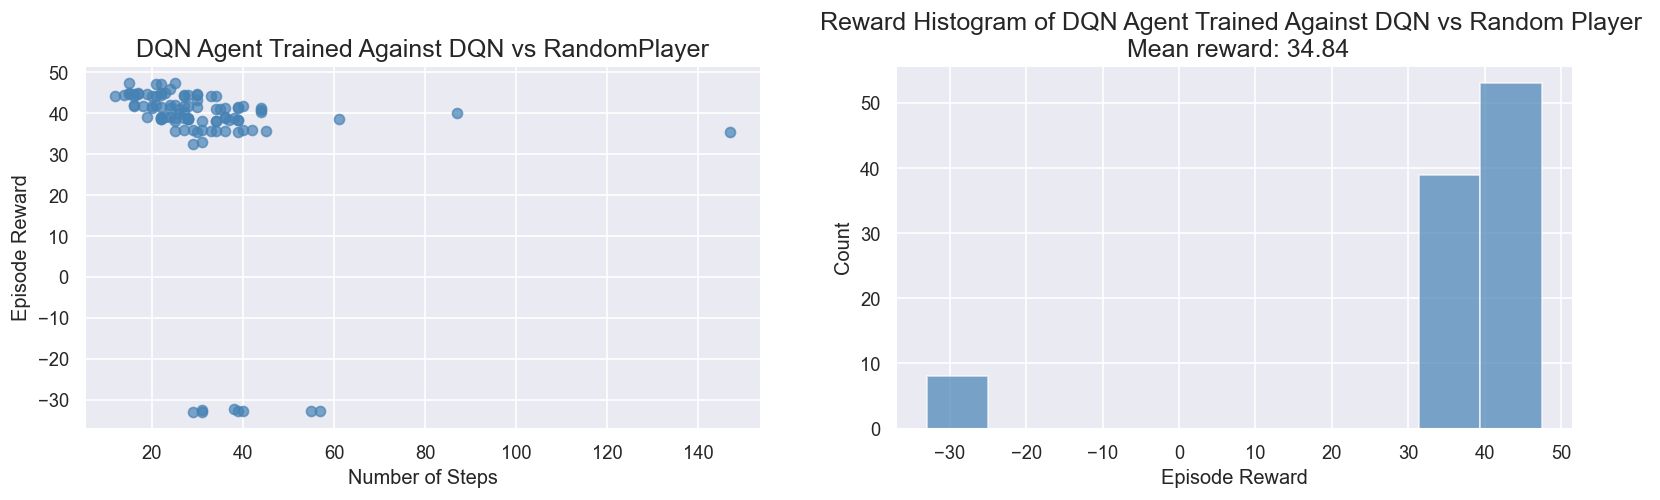

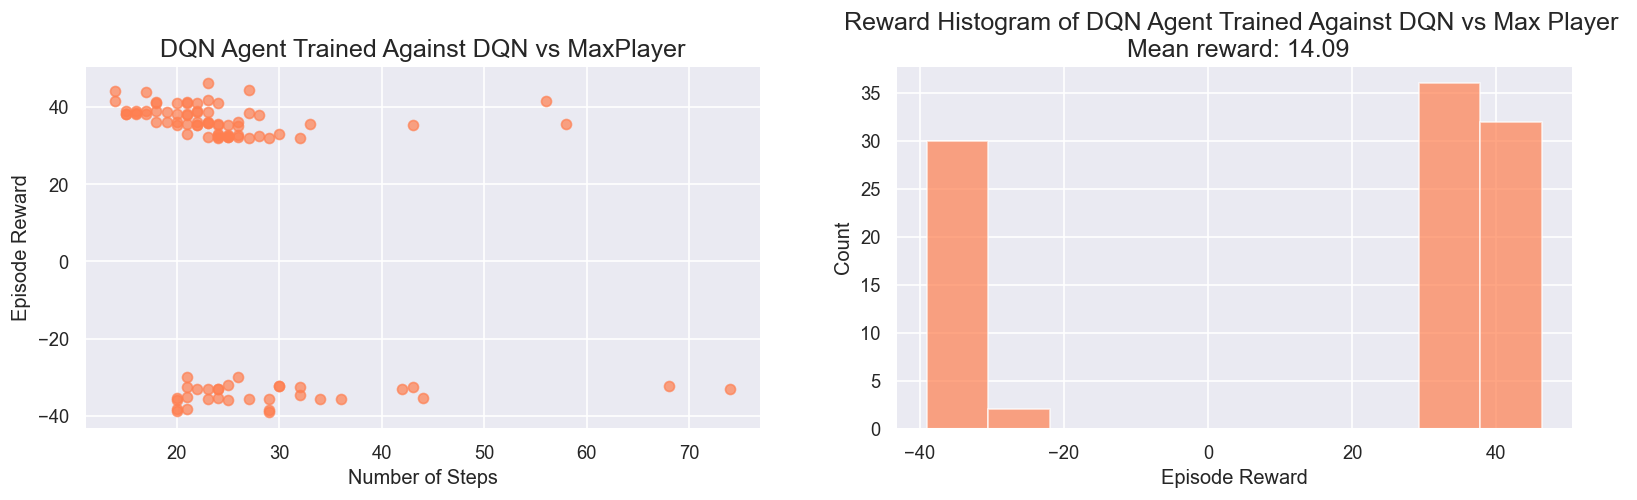

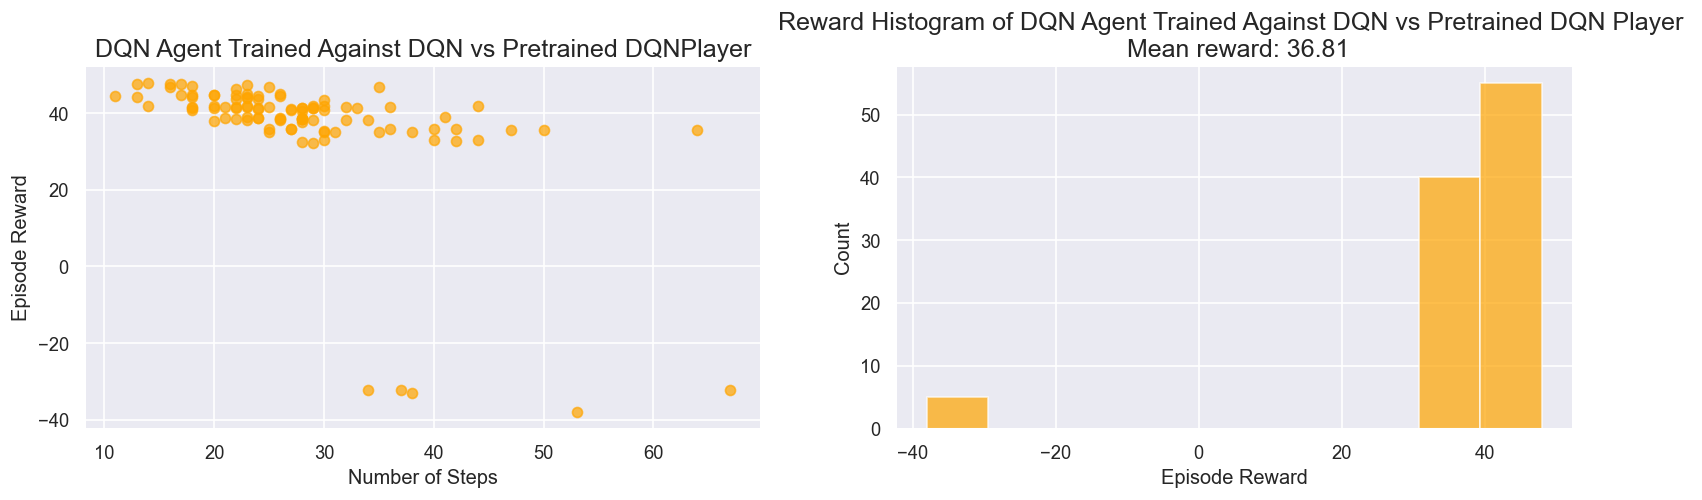

In [10]:
rl_vs_random = create_df(f'Trained{TRAINING_OPPONENT}({NB_TRAINING_STEPS})vsRandomPlayer_testlog_{NB_EVALUATION_EPISODES}eps.csv')
create_plots(rl_vs_random, 'DQN vs Random', 'SteelBlue')

rl_vs_max = create_df(f'Trained{TRAINING_OPPONENT}({NB_TRAINING_STEPS})vsMaxPlayer_testlog_{NB_EVALUATION_EPISODES}eps.csv')
create_plots(rl_vs_max, 'DQN vs Max', 'coral')

rl_vs_rl = create_df(f'Trained{TRAINING_OPPONENT}({NB_TRAINING_STEPS})vsRLPlayer_testlog_{NB_EVALUATION_EPISODES}eps.csv')
create_plots(rl_vs_rl, 'DQN vs Pretrained DQN', 'orange')